<a href="https://colab.research.google.com/github/LucaswasTaken/Openhardware-hpc/blob/master/notebooks/Aula3_GPU_Computing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ⚡ Aula 3 – GPUs em Python e Aplicações em Engenharia

## Computação de Alto Desempenho em Python para Engenharia Civil

**Objetivos desta aula:**
- Introduzir paralelismo massivo com GPU
- Usar CuPy (NumPy para GPU) e Numba CUDA
- Aplicar HPC a simulações reais (difusão de calor)
- Comparar performance CPU vs GPU

---

### 🎯 CPU vs GPU: Filosofias Diferentes

**CPU (Central Processing Unit):**
- Poucos núcleos complexos (4-64 cores)
- Otimizada para latência (velocidade individual)
- Hierarquia de cache complexa
- Ideal para código sequencial e ramificado

**GPU (Graphics Processing Unit):**
- Milhares de núcleos simples (1000+ cores)
- Otimizada para throughput (trabalho total)
- Arquitetura SIMD (Single Instruction, Multiple Data)
- Ideal para paralelismo massivo e dados regulares

### 🏗️ Aplicações GPU em Engenharia Civil
- **Simulações CFD** (Computational Fluid Dynamics)
- **Análise modal** de estruturas complexas
- **Processamento de imagens** (inspeção, monitoramento)
- **Machine Learning** para predição de falhas

In [1]:
# Colab setup: detect if running on Google Colab and optionally install GPU packages
try:
    import google.colab
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    print("⚙️ Detected Google Colab runtime. Preparing Colab-friendly environment...")
    import sys, subprocess, time
    import os # Import os module

    # Set Numba CUDA compute capability to a compatible version
    # This addresses LinkerError: Unsupported .version 8.5; current version is '8.4'
    os.environ['NUMBA_CUDA_CC'] = '8.0' # Target compute capability 8.0

    def pip_install(pkg):
        try:
            print(f"Installing {pkg}... (this may take a few minutes)")
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', pkg])
            return True
        except Exception as e:
            print(f"Failed to install {pkg}: {e}")
            return False

    # Try to install a CuPy wheel that matches the runtime's CUDA where possible.
    # We'll attempt CUDA12 then CUDA11 then plain cupy as fallbacks.
    cupy_installed = False
    for candidate in ['cupy-cuda12x', 'cupy-cuda11x', 'cupy']:
        if pip_install(candidate):
            cupy_installed = True
            break

    # Install numba (lightweight) to enable Numba CUDA cells if compatible
    pip_install('numba')

    # Quick GPU check
    try:
        import cupy as cp
        print("✅ CuPy available in Colab:", cp.__version__)
        try:
            props = cp.cuda.runtime.getDeviceProperties(0)
            name = props['name']
            if isinstance(name, bytes):
                name = name.decode()
            print(f"   GPU: {name}")
        except Exception:
            pass
    except Exception:
        print("⚠️ CuPy not available after install attempts. Some GPU cells may not run.")

    print("\nNote: If you installed new system packages, you may need to: Runtime -> Restart runtime")
else:
    print("Not running on Google Colab. Skipping Colab-specific setup.")

⚙️ Detected Google Colab runtime. Preparing Colab-friendly environment...
Installing cupy-cuda12x... (this may take a few minutes)
Installing numba... (this may take a few minutes)
✅ CuPy available in Colab: 13.3.0
   GPU: Tesla T4

Note: If you installed new system packages, you may need to: Runtime -> Restart runtime


In [2]:
# Import Required Libraries
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import multiprocessing as mp

# Tentar importar bibliotecas GPU
try:
    import cupy as cp
    CUPY_AVAILABLE = True
    print(f"✅ CuPy {cp.__version__} disponível")
    print(f"   GPU: {cp.cuda.runtime.getDeviceProperties(0)['name'].decode()}")
    print(f"   Memória: {cp.cuda.runtime.memGetInfo()[1] // (1024**3)} GB")
except ImportError:
    CUPY_AVAILABLE = False
    print("⚠️  CuPy não disponível - instale com: pip install cupy-cuda11x (ou cupy-cuda12x)")

try:
    from numba import cuda
    import numba
    NUMBA_CUDA_AVAILABLE = True
    print(f"✅ Numba CUDA {numba.__version__} disponível")
except ImportError:
    NUMBA_CUDA_AVAILABLE = False
    print("⚠️  Numba CUDA não disponível")

# Configure matplotlib
plt.style.use('seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else 'default')
plt.rcParams['figure.figsize'] = (12, 8)

print(f"n🖥️  Sistema: {mp.cpu_count()} núcleos CPU")
print(f"📊 NumPy: {np.__version__}")

if not CUPY_AVAILABLE and not NUMBA_CUDA_AVAILABLE:
    print("n⚠️  Nota: Esta aula requer GPU NVIDIA e CUDA para funcionalidade completa")
    print("   Mas ainda podemos aprender os conceitos e ver simulações CPU!")

✅ CuPy 13.3.0 disponível
   GPU: Tesla T4
   Memória: 14 GB
✅ Numba CUDA 0.60.0 disponível
n🖥️  Sistema: 2 núcleos CPU
📊 NumPy: 2.0.2


## 1. Exemplo 10: Soma de Vetores com CuPy

CuPy oferece uma interface NumPy para GPUs - mudança mínima de código!

In [4]:
if CUPY_AVAILABLE:
    print("🚀 Exemplo 10: Soma de Vetores com CuPy")
    print("=" * 40)

    # Teste com diferentes tamanhos de vetores
    sizes = [1_000_000, 10_000_000, 100_000_000]

    for N in sizes:
        print(f"n📊 Tamanho: {N:,} elementos")

        # Criar vetores no CPU
        print("  Criando dados no CPU...")
        a_cpu = np.random.randn(N).astype(np.float32)
        b_cpu = np.random.randn(N).astype(np.float32)

        # NumPy (CPU)
        start = time.perf_counter()
        c_cpu = a_cpu + b_cpu
        time_cpu = time.perf_counter() - start
        print(f"  NumPy (CPU):     {time_cpu:.4f}s")

        # Transferir para GPU
        start_transfer = time.perf_counter()
        a_gpu = cp.asarray(a_cpu)
        b_gpu = cp.asarray(b_cpu)
        time_transfer_to = time.perf_counter() - start_transfer

        # CuPy (GPU)
        start = time.perf_counter()
        c_gpu = a_gpu + b_gpu
        cp.cuda.Stream.null.synchronize()
        time_gpu = time.perf_counter() - start

        # Transferir resultado de volta
        start_transfer = time.perf_counter()
        c_gpu_cpu = cp.asnumpy(c_gpu)
        time_transfer_back = time.perf_counter() - start_transfer

        # Verificar correção
        are_equal = np.allclose(c_cpu, c_gpu_cpu, rtol=1e-5)

        # Speedup considerando apenas computação
        speedup_compute = time_cpu / time_gpu

        # Speedup total (incluindo transferências)
        total_gpu_time = time_transfer_to + time_gpu + time_transfer_back
        speedup_total = time_cpu / total_gpu_time

        print(f"  CuPy (GPU):      {time_gpu:.4f}s")
        print(f"  Transferência:   {time_transfer_to + time_transfer_back:.4f}s")
        print(f"  Total GPU:       {total_gpu_time:.4f}s")
        print(f"  Speedup (comp):  {speedup_compute:.2f}x")
        print(f"  Speedup (total): {speedup_total:.2f}x")
        print(f"  Precisão:        {'✓' if are_equal else '✗'}")

    print("n💡 Observações importantes:")
    print("• Transferência CPU↔GPU é custosa")
    print("• Speedup real depende do tamanho do problema")
    print("• GPU é mais eficiente para problemas grandes")
    print("• CuPy = np → cp (mudança mínima de código)")

else:
    print("⚠️  CuPy não disponível. Exemplo conceitual:")
    print("""
    # NumPy (CPU)
    import numpy as np
    a = np.arange(10_000_000)
    b = np.arange(10_000_000)
    c = a + b  # Executa no CPU

    # CuPy (GPU) - mudança mínima!
    import cupy as cp
    a = cp.arange(10_000_000)  # Criado diretamente na GPU
    b = cp.arange(10_000_000)
    c = a + b  # Executa na GPU automaticamente!
    """)

🚀 Exemplo 10: Soma de Vetores com CuPy
n📊 Tamanho: 1,000,000 elementos
  Criando dados no CPU...
  NumPy (CPU):     0.0022s
  CuPy (GPU):      0.0005s
  Transferência:   0.0103s
  Total GPU:       0.0108s
  Speedup (comp):  4.79x
  Speedup (total): 0.20x
  Precisão:        ✓
n📊 Tamanho: 10,000,000 elementos
  Criando dados no CPU...
  NumPy (CPU):     0.0236s
  CuPy (GPU):      0.0042s
  Transferência:   0.0467s
  Total GPU:       0.0509s
  Speedup (comp):  5.58x
  Speedup (total): 0.46x
  Precisão:        ✓
n📊 Tamanho: 100,000,000 elementos
  Criando dados no CPU...
  NumPy (CPU):     0.1503s
  CuPy (GPU):      0.0405s
  Transferência:   0.3469s
  Total GPU:       0.3873s
  Speedup (comp):  3.71x
  Speedup (total): 0.39x
  Precisão:        ✓
n💡 Observações importantes:
• Transferência CPU↔GPU é custosa
• Speedup real depende do tamanho do problema
• GPU é mais eficiente para problemas grandes
• CuPy = np → cp (mudança mínima de código)


## 2. Exemplo 11: Multiplicação de Matrizes Massivas

Para matrizes grandes, GPUs mostram seu verdadeiro poder!

In [ ]:
if CUPY_AVAILABLE:
    print("🧮 Exemplo 11: Multiplicação de Matrizes Massivas")
    print("=" * 50)

    # Testar diferentes tamanhos de matrizes
    matrix_sizes = [1024, 2048, 4096]

    for size in matrix_sizes:
        print(f"n📊 Matrizes {size}x{size} (elementos: {size**2:,})")

        # Criar matrizes aleatórias
        print("  Gerando matrizes aleatórias...")
        np.random.seed(42)
        A_cpu = np.random.randn(size, size).astype(np.float32)
        B_cpu = np.random.randn(size, size).astype(np.float32)

        # NumPy (CPU) com BLAS otimizado
        print("  Executando multiplicação no CPU...")
        start = time.perf_counter()
        C_cpu = np.dot(A_cpu, B_cpu)
        time_cpu = time.perf_counter() - start
        print(f"  NumPy (CPU):     {time_cpu:.4f}s")

        # Transferir para GPU
        start = time.perf_counter()
        A_gpu = cp.asarray(A_cpu)
        B_gpu = cp.asarray(B_cpu)
        time_transfer_to = time.perf_counter() - start
        print(f"  Transferência→GPU: {time_transfer_to:.4f}s")

        # CuPy (GPU)
        print("  Executando multiplicação na GPU...")
        start = time.perf_counter()
        C_gpu = cp.dot(A_gpu, B_gpu)
        cp.cuda.Stream.null.synchronize()
        time_gpu = time.perf_counter() - start
        print(f"  CuPy (GPU):      {time_gpu:.4f}s")

        # Transferir resultado de volta
        start = time.perf_counter()
        C_gpu_cpu = cp.asnumpy(C_gpu)
        time_transfer_back = time.perf_counter() - start
        print(f"  Transferência←GPU: {time_transfer_back:.4f}s")

        # Verificar precisão
        max_error = np.max(np.abs(C_cpu - C_gpu_cpu))
        are_close = np.allclose(C_cpu, C_gpu_cpu, rtol=1e-4)

        # Calcular speedups
        speedup_compute = time_cpu / time_gpu
        total_gpu_time = time_transfer_to + time_gpu + time_transfer_back
        speedup_total = time_cpu / total_gpu_time

        # Calcular FLOPS (operações de ponto flutuante por segundo)
        flops = 2 * size**3  # Multiplicação de matrizes: 2*n³ operações
        gflops_cpu = flops / (time_cpu * 1e9)
        gflops_gpu = flops / (time_gpu * 1e9)

        print(f"n  📈 Performance:")
        print(f"    CPU GFLOPS:      {gflops_cpu:.2f}")
        print(f"    GPU GFLOPS:      {gflops_gpu:.2f}")
        print(f"    Speedup (comp):  {speedup_compute:.2f}x")
        print(f"    Speedup (total): {speedup_total:.2f}x")
        print(f"    Erro máximo:     {max_error:.2e}")
        print(f"    Precisão:        {'✓' if are_close else '✗'}")

        # Limpeza de memória GPU
        del A_gpu, B_gpu, C_gpu
        cp.get_default_memory_pool().free_all_blocks()

    print("n💡 Observações:")
    print("• GPU acelera significativamente operações matriciais grandes")
    print("• GFLOPS (Giga FLOPS) mede eficiência computacional")
    print("• Speedup melhora com tamanho do problema")
    print("• Essencial considerar overhead de transferência")

else:
    print("⚠️  Demonstração conceitual de multiplicação de matrizes GPU:")

    # Simular performance típica
    sizes = [1024, 2048, 4096]
    print("Speedups típicos para multiplicação de matrizes:")
    print("Tamanho    CPU (s)    GPU (s)    Speedup")
    print("-" * 40)

    for size in sizes:
        # Estimativas baseadas em hardware típico
        flops = 2 * size**3
        time_cpu_est = flops / (100e9)  # ~100 GFLOPS CPU
        time_gpu_est = flops / (2000e9)  # ~2000 GFLOPS GPU
        speedup_est = time_cpu_est / time_gpu_est

        print(f"{size:>6}x{size:<6} {time_cpu_est:.3f}     {time_gpu_est:.4f}    {speedup_est:.1f}x")

🧮 Exemplo 11: Multiplicação de Matrizes Massivas
n📊 Matrizes 1024x1024 (elementos: 1,048,576)
  Gerando matrizes aleatórias...
  Executando multiplicação no CPU...
  NumPy (CPU):     0.0229s
  Transferência→GPU: 0.0043s
  Executando multiplicação na GPU...
  CuPy (GPU):      0.5485s
  Transferência←GPU: 0.0024s
n  📈 Performance:
    CPU GFLOPS:      93.71
    GPU GFLOPS:      3.92
    Speedup (comp):  0.04x
    Speedup (total): 0.04x
    Erro máximo:     9.92e-05
    Precisão:        ✗
n📊 Matrizes 2048x2048 (elementos: 4,194,304)
  Gerando matrizes aleatórias...
  Executando multiplicação no CPU...
  NumPy (CPU):     0.1406s
  Transferência→GPU: 0.0263s
  Executando multiplicação na GPU...
  CuPy (GPU):      0.0073s
  Transferência←GPU: 0.0075s
n  📈 Performance:
    CPU GFLOPS:      122.22
    GPU GFLOPS:      2352.82
    Speedup (comp):  19.25x
    Speedup (total): 3.42x
    Erro máximo:     2.67e-04
    Precisão:        ✗
n📊 Matrizes 4096x4096 (elementos: 16,777,216)
  Gerando matriz

## 3. Exemplo 13: Simulação de Difusão de Calor 2D

Vamos implementar uma simulação realística de engenharia: difusão de calor em uma placa metálica.

🌡️  Exemplo 13: Simulação de Difusão de Calor 2D
Parâmetros da simulação:
  Malha: 256x256 = 65,536 pontos
  Passos de tempo: 100
  dt = 9.61e-03s (estabilidade: 0.062 < 0.25)
nCondições iniciais: fonte de calor central a 100°C
n⏱️  Executando simulação no CPU...
CPU: 13.644s
n⏱️  Executando simulação na GPU (CuPy)...
GPU (CuPy): 0.775s, speedup: 17.60x
Diferença máxima CPU vs GPU: 6.02e-36°C


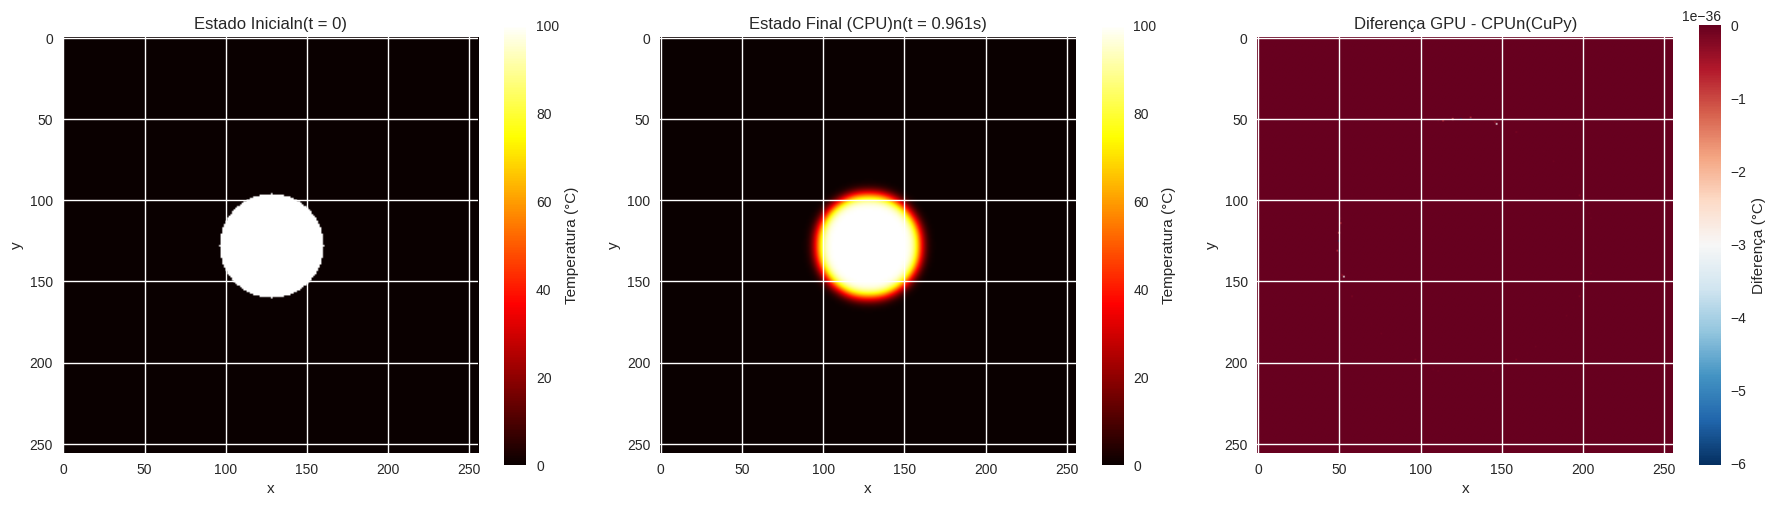

n💡 Aplicações em Engenharia Civil:
• Análise térmica de estruturas de concreto
• Simulação de incêndios em edificações
• Comportamento térmico de pavimentos
• Isolamento térmico de edifícios
• Pontes térmicas em estruturas


In [ ]:
def heat_equation_cpu(T, alpha, dx, dy, dt, steps):
    """
    Simula difusão de calor 2D no CPU
    Equação: ∂T/∂t = α(∂²T/∂x² + ∂²T/∂y²)
    """
    ny, nx = T.shape
    T_new = T.copy()

    start = time.perf_counter()

    for step in range(steps):
        # Atualizar pontos internos usando diferenças finitas
        for i in range(1, ny-1):
            for j in range(1, nx-1):
                T_new[i, j] = T[i, j] + alpha * dt * (
                    (T[i+1, j] - 2*T[i, j] + T[i-1, j]) / dx**2 +
                    (T[i, j+1] - 2*T[i, j] + T[i, j-1]) / dy**2
                )

        # Trocar arrays
        T, T_new = T_new, T

    exec_time = time.perf_counter() - start
    return T, exec_time

if CUPY_AVAILABLE:
    def heat_equation_gpu(T_gpu, alpha, dx, dy, dt, steps):
        """Simula difusão de calor 2D na GPU usando CuPy"""
        ny, nx = T_gpu.shape
        T_new_gpu = cp.copy(T_gpu)

        start = time.perf_counter()

        for step in range(steps):
            # Atualizar usando slicing vetorizado
            T_new_gpu[1:-1, 1:-1] = T_gpu[1:-1, 1:-1] + alpha * dt * (
                (T_gpu[2:, 1:-1] - 2*T_gpu[1:-1, 1:-1] + T_gpu[:-2, 1:-1]) / dx**2 +
                (T_gpu[1:-1, 2:] - 2*T_gpu[1:-1, 1:-1] + T_gpu[1:-1, :-2]) / dy**2
            )

            # Trocar arrays
            T_gpu, T_new_gpu = T_new_gpu, T_gpu

        cp.cuda.Stream.null.synchronize()
        exec_time = time.perf_counter() - start
        return T_gpu, exec_time

print("🌡️  Exemplo 13: Simulação de Difusão de Calor 2D")
print("=" * 50)

# Parâmetros físicos
Lx, Ly = 1.0, 1.0  # Dimensões da placa (metros)
nx, ny = 256, 256  # Pontos da malha
dx = Lx / (nx - 1)
dy = Ly / (ny - 1)
alpha = 1e-4  # Difusividade térmica (m²/s)
dt = 0.25 * min(dx, dy)**2 / (4 * alpha)  # Passo de tempo estável
steps = 100  # Número de passos de tempo

print(f"Parâmetros da simulação:")
print(f"  Malha: {nx}x{ny} = {nx*ny:,} pontos")
print(f"  Passos de tempo: {steps}")
print(f"  dt = {dt:.2e}s (estabilidade: {dt*alpha/(dx**2):.3f} < 0.25)")

# Condições iniciais e de contorno
T_initial = np.zeros((ny, nx), dtype=np.float32)

# Fonte de calor no centro
center_x, center_y = nx//2, ny//2
radius = min(nx, ny) // 8
for i in range(ny):
    for j in range(nx):
        if (i - center_y)**2 + (j - center_x)**2 <= radius**2:
            T_initial[i, j] = 100.0  # 100°C

# Bordas mantidas a 0°C (condição de Dirichlet)
T_initial[0, :] = T_initial[-1, :] = 0.0
T_initial[:, 0] = T_initial[:, -1] = 0.0

print(f"nCondições iniciais: fonte de calor central a 100°C")

# Simular no CPU
print("n⏱️  Executando simulação no CPU...")
T_cpu, time_cpu = heat_equation_cpu(T_initial.copy(), alpha, dx, dy, dt, steps)
print(f"CPU: {time_cpu:.3f}s")

# Simular na GPU (se disponível)
if CUPY_AVAILABLE:
    print("n⏱️  Executando simulação na GPU (CuPy)...")
    T_gpu_cupy, time_gpu_cupy = heat_equation_gpu(cp.asarray(T_initial), alpha, dx, dy, dt, steps)
    T_gpu_cupy_host = cp.asnumpy(T_gpu_cupy)

    speedup_cupy = time_cpu / time_gpu_cupy
    max_diff_cupy = np.max(np.abs(T_cpu - T_gpu_cupy_host))

    print(f"GPU (CuPy): {time_gpu_cupy:.3f}s, speedup: {speedup_cupy:.2f}x")
    print(f"Diferença máxima CPU vs GPU: {max_diff_cupy:.2e}°C")

# Visualização dos resultados
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Estado inicial
im1 = axes[0].imshow(T_initial, cmap='hot', interpolation='bilinear')
axes[0].set_title('Estado Inicialn(t = 0)')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
plt.colorbar(im1, ax=axes[0], label='Temperatura (°C)')

# Estado final (CPU)
im2 = axes[1].imshow(T_cpu, cmap='hot', interpolation='bilinear')
axes[1].set_title(f'Estado Final (CPU)n(t = {steps*dt:.3f}s)')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
plt.colorbar(im2, ax=axes[1], label='Temperatura (°C)')

# Comparação GPU vs CPU (se disponível)
if CUPY_AVAILABLE:
    diff = T_gpu_cupy_host - T_cpu
    im3 = axes[2].imshow(diff, cmap='RdBu_r', interpolation='bilinear')
    axes[2].set_title('Diferença GPU - CPUn(CuPy)')
    axes[2].set_xlabel('x')
    axes[2].set_ylabel('y')
    plt.colorbar(im3, ax=axes[2], label='Diferença (°C)')
else:
    # Perfil de temperatura no centro
    center_line = T_cpu[ny//2, :]
    axes[2].plot(np.linspace(0, Lx, nx), center_line, 'r-', linewidth=2)
    axes[2].set_title('Perfil de Temperaturan(linha central)')
    axes[2].set_xlabel('Posição x (m)')
    axes[2].set_ylabel('Temperatura (°C)')
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("n💡 Aplicações em Engenharia Civil:")
print("• Análise térmica de estruturas de concreto")
print("• Simulação de incêndios em edificações")
print("• Comportamento térmico de pavimentos")
print("• Isolamento térmico de edifícios")
print("• Pontes térmicas em estruturas")